## Project Description 
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!
As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.
Ref: DataCamp


## Dataset
The dataset comprises information from 90,189 players who installed the game during an ongoing AB-test. It includes the following variables:

userid: A unique identifier assigned to each player.
version: Indicates whether the player belongs to the control group (gate_30 - featuring a gate at level 30) or the test group (gate_40 - featuring a gate at level 40).
sum_gamerounds: Represents the number of game rounds played by the player within the first week after installing the game.
retention_1: Indicates whether the player returned to play the game one day after installation.
retention_7: Indicates whether the player returned to play the game seven days after installation.
Upon installing the game, each player was randomly assigned to one of two groups: gate_30 or gate_40.



##A/B testing

The process of conducting AB testing involves the following steps:

Understanding the Business Problem & Data: Gain a clear understanding of the business problem and the dataset's context.

Data Preprocessing: Detect and address issues in the data, such as missing values, outliers, and unexpected data entries.

Exploratory Data Analysis (EDA): Explore the data through summary statistics and visualizations to gain insights.

Hypothesis Testing: Apply hypothesis testing to draw statistical inferences. This includes checking assumptions, such as normality and homogeneity.

Statistical Testing: Conduct statistical tests, such as the Shapiro-Wilk test, Levene's test, t-test, Welch's test, or Mann-Whitney U test, depending on data characteristics and assumptions.

Evaluation of Results: Interpret the results of the statistical tests and draw meaningful conclusions.

Inference and Recommendations: Make informed inferences and provide recommendations or business decisions based on the analysis to stakeholders, including customers, directors, or CEOs.

The AB testing process aims to assess the impact of changing the gate location in the game (from level 30 to level 40) on player behavior and retention, helping to inform strategic decisions.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns


In [2]:
# Load the data into Pandas dataframes
df = pd.read_csv('Desktop/Data/cookie_cats.csv')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.userid.nunique()

90189

In [5]:
# Number of Unique User
print(df.userid.nunique() == df.shape[0])

True


In [6]:
df.shape

(90189, 5)

In [7]:
# Define the list of percentiles you want to include in the summary
percentiles = [0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99]

# Calculate summary statistics for the specified percentiles
summary_stats = df["sum_gamerounds"].describe(percentiles=percentiles).T

# Display the summary statistics for the "sum_gamerounds" variable
summary_stats

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
1%           0.000000
5%           1.000000
10%          1.000000
20%          3.000000
50%         16.000000
80%         67.000000
90%        134.000000
95%        221.000000
99%        493.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [8]:
# A/B Groups & Target Summary Stats

# Define the list of percentiles you want to include in the summary
percentiles = [0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99]

# Calculate summary statistics for the specified percentiles for each version
summary_stats = df.groupby("version")["sum_gamerounds"].describe(percentiles=percentiles).T

# Display the summary statistics for the "sum_gamerounds" variable by version
summary_stats


version,gate_30,gate_40
count,44700.000000,45489.000000
mean,52.456264,51.298776
std,256.716423,103.294416
min,0.000000,0.000000
1%,0.000000,0.000000
5%,1.000000,1.000000
10%,1.000000,1.000000
20%,4.000000,3.000000
50%,17.000000,16.000000
80%,66.000000,68.000000


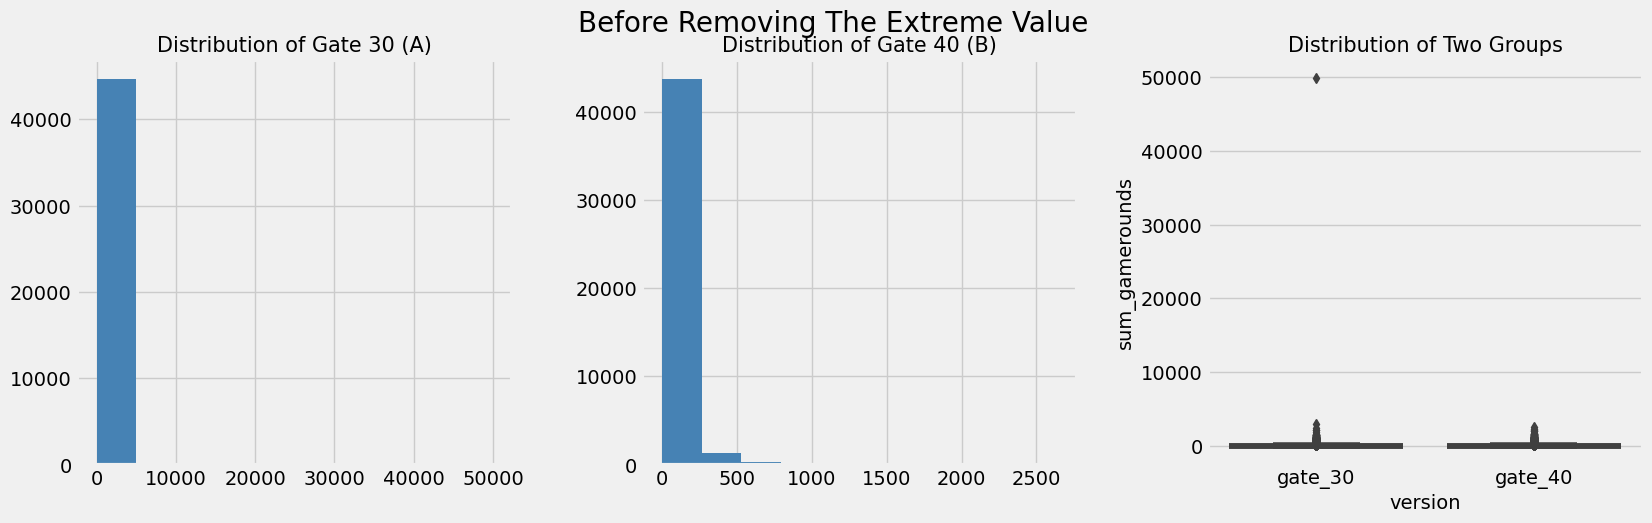

In [9]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot histograms for Gate 30 (Group A)
df[df.version == "gate_30"].hist("sum_gamerounds", ax=axes[0], color="steelblue")
axes[0].set_title("Distribution of Gate 30 (A)", fontsize=15)

# Plot histograms for Gate 40 (Group B)
df[df.version == "gate_40"].hist("sum_gamerounds", ax=axes[1], color="steelblue")
axes[1].set_title("Distribution of Gate 40 (B)", fontsize=15)

# Plot a boxplot comparing the two groups
sns.boxplot(x=df.version, y=df.sum_gamerounds, ax=axes[2])
axes[2].set_title("Distribution of Two Groups", fontsize=15)

# Add a main title
plt.suptitle("Before Removing The Extreme Value", fontsize=20)

# Adjust subplot layout
plt.tight_layout

# Display the plots
plt.show()

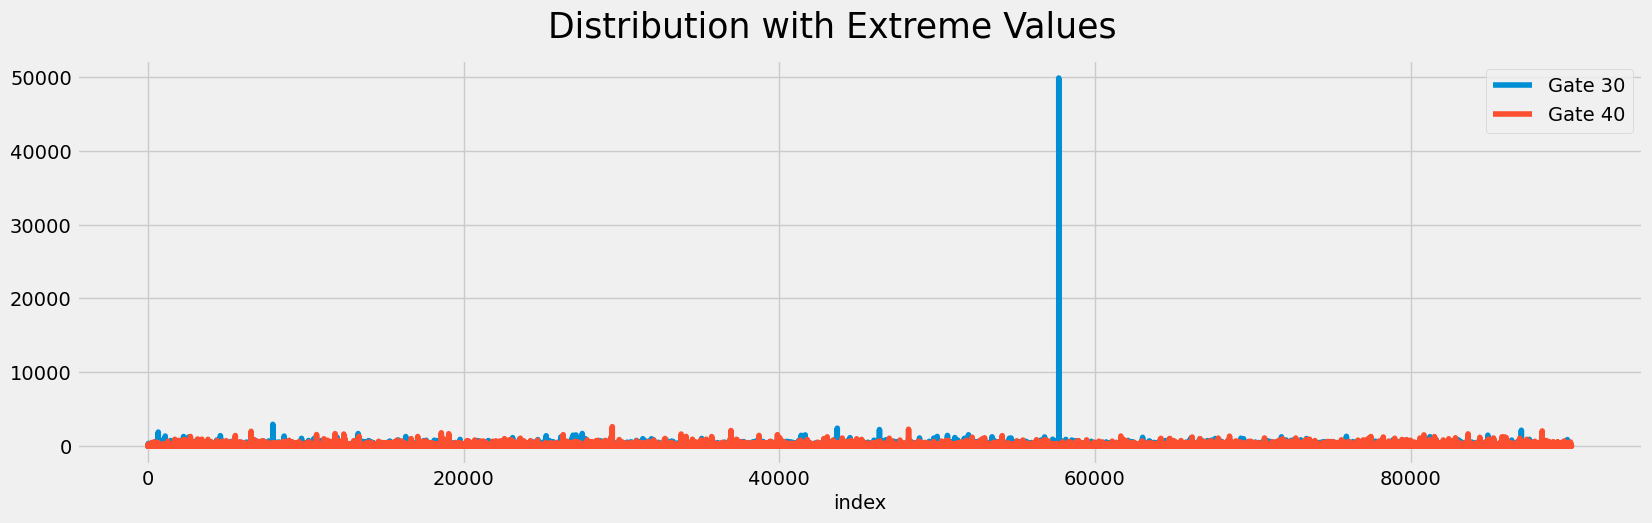

In [10]:
# Filter data for Gate 30 (Group A) and Gate 40 (Group B), reset index, and set index to "index"
gate_30_data = df[df.version == "gate_30"].reset_index().set_index("index")
gate_40_data = df[df.version == "gate_40"].reset_index().set_index("index")

# Plot game rounds for Gate 30 with a legend and label
gate_30_data.sum_gamerounds.plot(legend=True, label="Gate 30", figsize=(18, 5))

# Plot game rounds for Gate 40 with a legend and label
gate_40_data.sum_gamerounds.plot(legend=True, label="Gate 40")

# Add a super title
plt.suptitle("Distribution with Extreme Values", fontsize=25)

# Display the plot
plt.show()

# **Outliers**


In [11]:
ab = df[df.sum_gamerounds < df.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0,51.320253,102.682719,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,2961.0


In [12]:

# Define the list of percentiles you want to include in the summary
percentiles = [0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99]

# Calculate summary statistics for the specified percentiles for each version
summary_stats = ab.groupby("version")["sum_gamerounds"].describe(percentiles=percentiles).T

# Display the summary statistics for the "sum_gamerounds" variable by version
summary_stats

version,gate_30,gate_40
count,44699.000000,45489.000000
mean,51.342111,51.298776
std,102.057598,103.294416
min,0.000000,0.000000
1%,0.000000,0.000000
5%,1.000000,1.000000
10%,1.000000,1.000000
20%,4.000000,3.000000
50%,17.000000,16.000000
80%,66.000000,68.000000


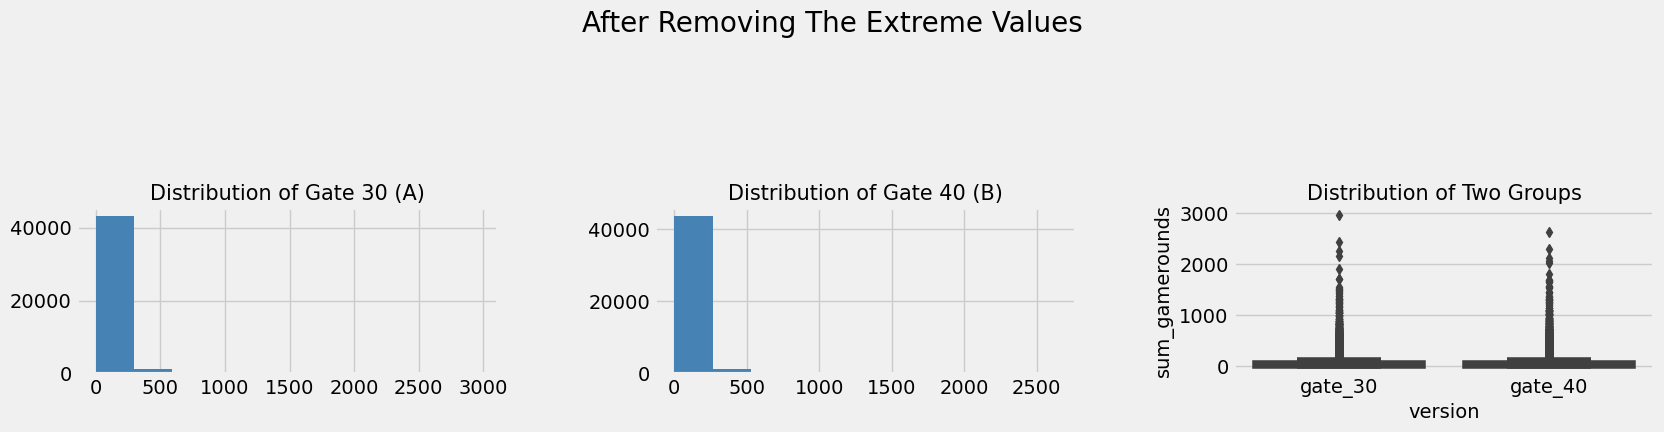

In [13]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot histograms for Gate 30 (Group A)
ab[ab.version == "gate_30"].hist("sum_gamerounds", ax=axes[0], color="steelblue")
axes[0].set_title("Distribution of Gate 30 (A)", fontsize=15)

# Plot histograms for Gate 40 (Group B)
ab[ab.version == "gate_40"].hist("sum_gamerounds", ax=axes[1], color="steelblue")
axes[1].set_title("Distribution of Gate 40 (B)", fontsize=15)

# Plot a boxplot comparing the two groups
sns.boxplot(x=ab.version, y=ab.sum_gamerounds, ax=axes[2])
axes[2].set_title("Distribution of Two Groups", fontsize=15)

# Add a main title
plt.suptitle("After Removing The Extreme Values", fontsize=20)

# Adjust subplot layout
plt.tight_layout(pad=4)

# Display the plots
plt.show()

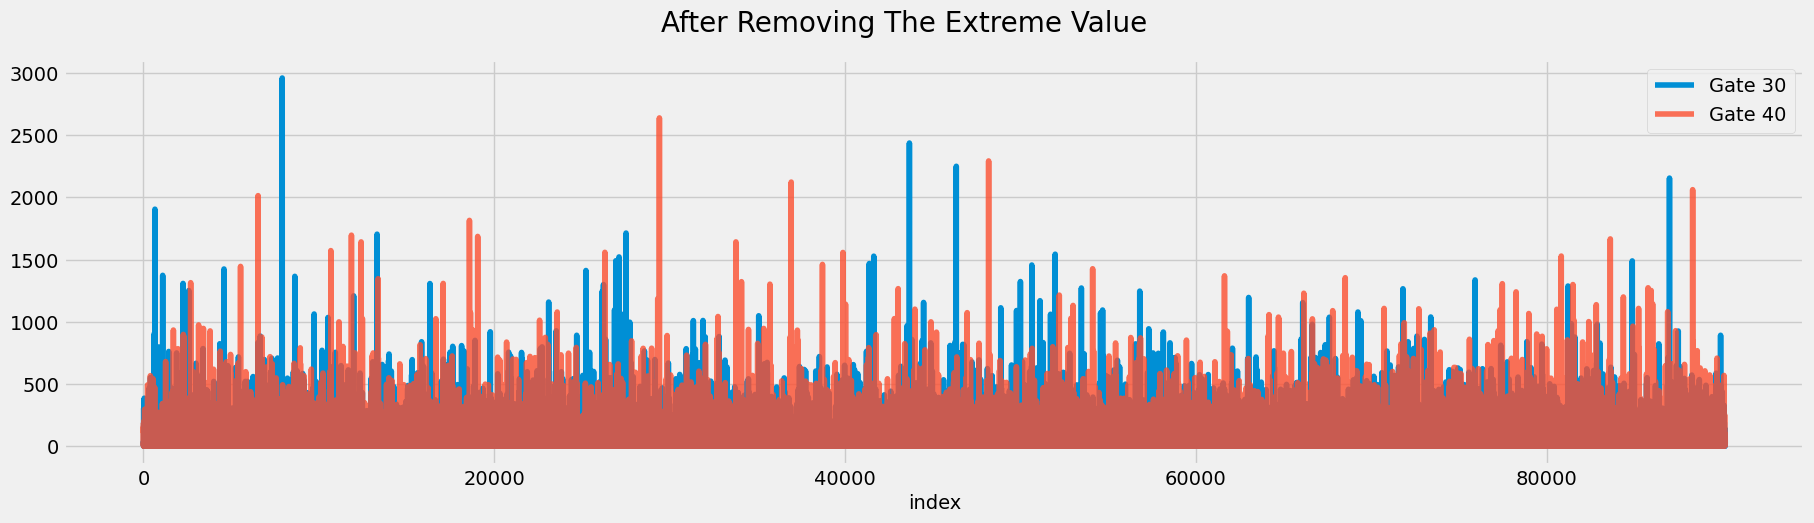

In [14]:
# Filter data for Gate 30 (Group A) and Gate 40 (Group B), reset index, and set index to "index"
gate_30_data = ab[ab.version == "gate_30"].reset_index().set_index("index")
gate_40_data = ab[ab.version == "gate_40"].reset_index().set_index("index")

# Plot game rounds for Gate 30
gate_30_data.sum_gamerounds.plot(legend=True, label="Gate 30", figsize=(20, 5))

# Plot game rounds for Gate 40 with reduced opacity (alpha)
gate_40_data.sum_gamerounds.plot(legend=True, label="Gate 40", alpha=0.8)

# Add a super title
plt.suptitle("After Removing The Extreme Value", fontsize=20)

# Display the plot
plt.show()

3,994 users who installed the game never engaged with it; potential reasons include:

Lack of available free time for gaming
Preference for other games or existing gaming commitments
Dislike for the app and its features
The user base tends to decline as game levels advance, with most players not progressing far.

Tactile Entertainment should investigate the reasons behind user churn.

Conducting research and gathering user data would facilitate comprehension of user churn factors.

Game difficulty can be quantified and assessed.

Introducing gifts could potentially enhance player retention.

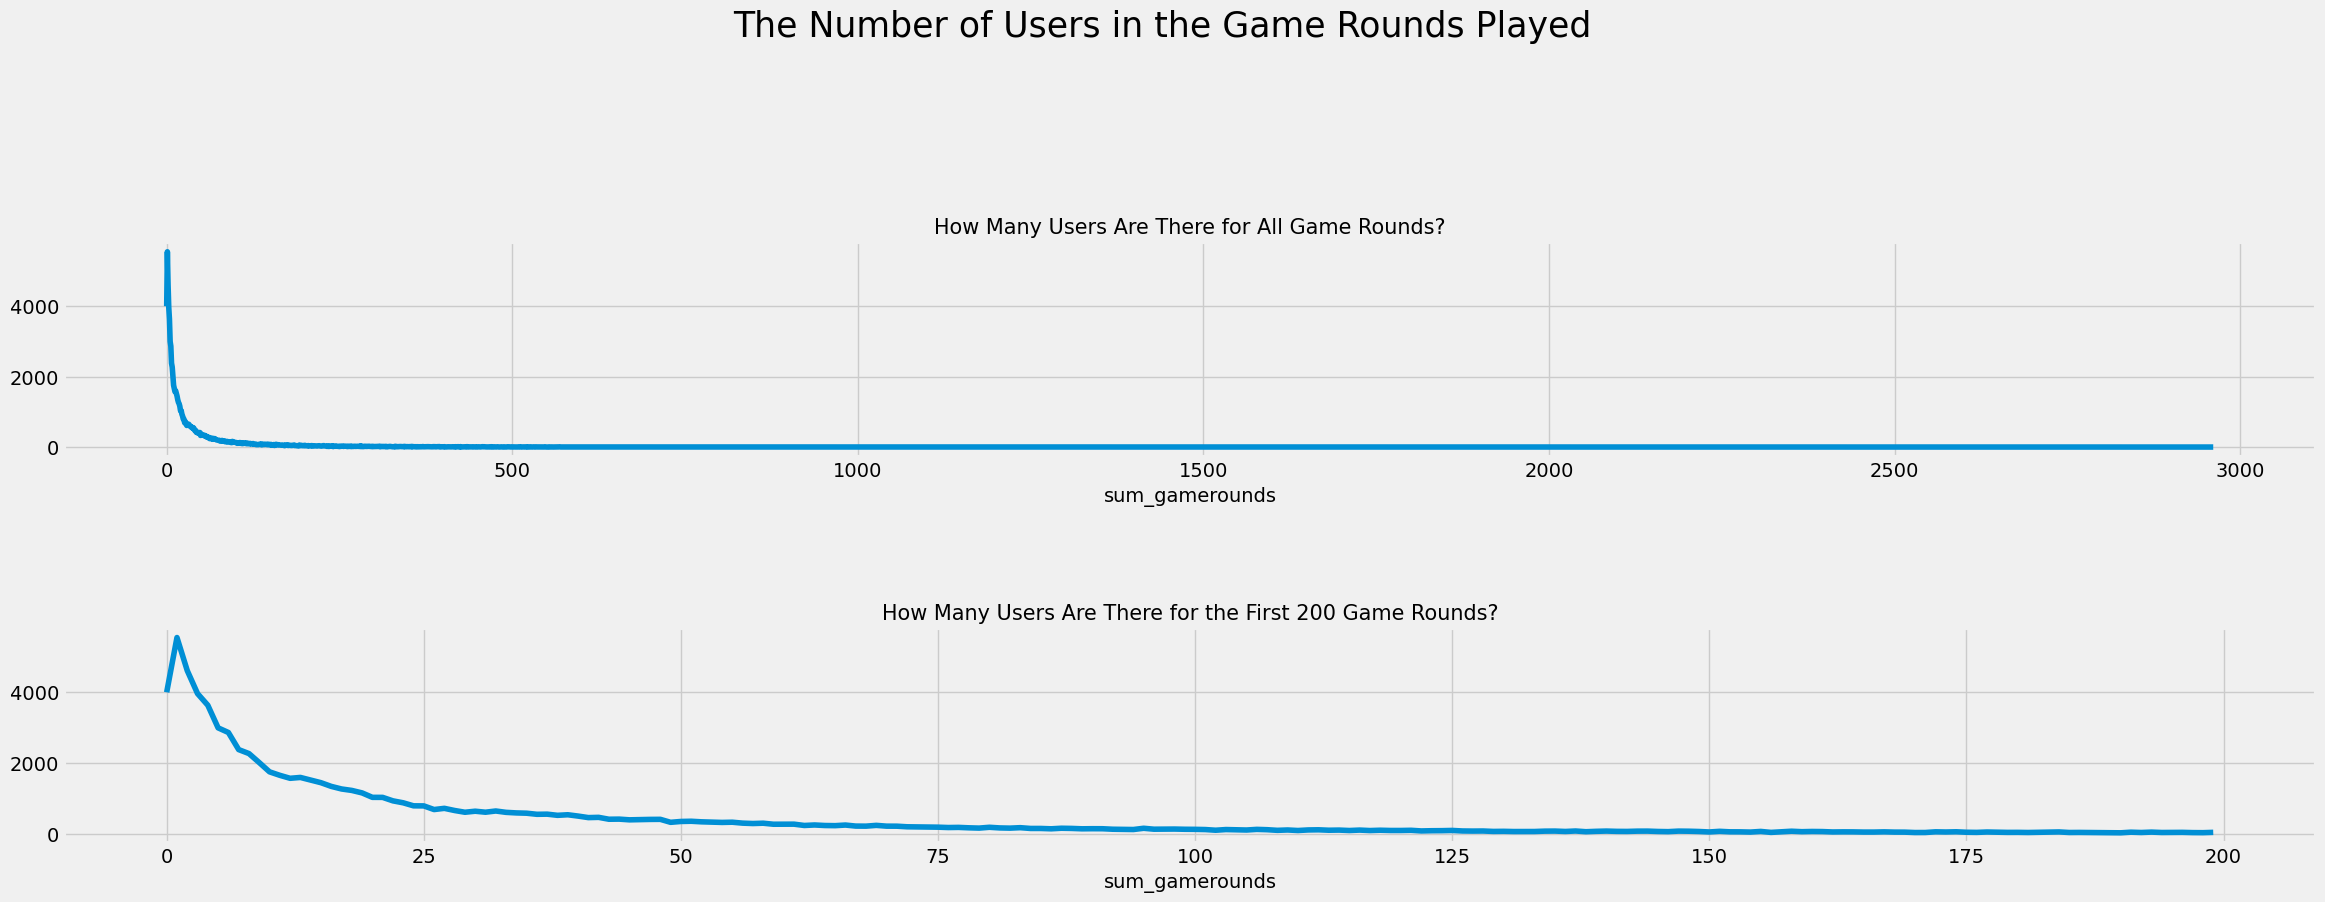

In [15]:
# Create subplots with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(25, 10))

# Plot the number of users for all game rounds
ab.groupby("sum_gamerounds").userid.count().plot(ax=axes[0])

# Plot the number of users for the first 200 game rounds
ab.groupby("sum_gamerounds").userid.count()[:200].plot(ax=axes[1])

# Add a super title
plt.suptitle("The Number of Users in the Game Rounds Played", fontsize=25)

# Set titles for individual subplots
axes[0].set_title("How Many Users Are There for All Game Rounds?", fontsize=15)
axes[1].set_title("How Many Users Are There for the First 200 Game Rounds?", fontsize=15)

# Adjust subplot layout
plt.tight_layout(pad=5)

# Display the plots
plt.show()

In [16]:
ab.groupby("sum_gamerounds").userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [17]:
# How many users reached gate 30 & gate 40 levels?
ab.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

Upon reviewing the summary statistics, it appears that the control and test groups share similarities. However, we will conduct a statistical analysis to determine whether these two groups exhibit significant differences.

In [18]:
# A/B Groups & Target Summary Stats
import pandas as pd

# Calculate summary statistics for A/B groups and the target variable
summary_stats = ab.groupby("version")["sum_gamerounds"].agg([
    "count",          # Number of observations
    "median",         # Median value
    "mean",           # Mean value
    "std",            # Standard deviation
    "max"             # Maximum value
])

# Rename the columns for clarity
summary_stats.columns = [
    "Count of Users",
    "Median Game Rounds",
    "Mean Game Rounds",
    "Standard Deviation",
    "Maximum Game Rounds"
]

# Display the summary statistics
summary_stats


,Count of Users,Median Game Rounds,Mean Game Rounds,Standard Deviation,Maximum Game Rounds
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


The retention variables provide us with insights into player retention, specifically:

retention_1: Indicates whether the player returned to the game one day after installation.
retention_7: Indicates whether the player returned to the game seven days after installation.
It's noteworthy that a significant portion of players tend to discontinue playing the game. To elaborate:

55 percent of players did not return to the game one day after installation.
81 percent of players did not return to the game seven days after installation.

In [19]:
# Retention Problem
pd.DataFrame({"RET1_COUNT": ab["retention_1"].value_counts(),
              "RET7_COUNT": ab["retention_7"].value_counts(),
              "RET1_RATIO": ab["retention_1"].value_counts() / len(ab),
              "RET7_RATIO": ab["retention_7"].value_counts() / len(ab)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


When examining the summary statistics of retention variables categorized by version and comparing them with the total sum of game rounds played, we observe resemblances across these groups. Nevertheless, it would be more informative to determine whether there exists a statistically significant difference.

In [20]:
ab.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median       mean         std   max
version retention_1                                            
gate_30 False        24665     6.0  16.359092   36.528426  1072
        True         20034    48.0  94.411700  135.037697  2961
gate_40 False        25370     6.0  16.340402   35.925756  1241
        True         20119    49.0  95.381182  137.887256  2640

In [21]:
ab.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198    11.0   25.796508   43.316158   981
        True          8501   105.0  160.117516  179.358560  2961
gate_40 False        37210    11.0   25.856356   44.406112  2640
        True          8279   111.0  165.649837  183.792499  2294

Comparable outcomes are observed when considering the count of users who engaged with the game within one day and seven days after installation. Among the entire user base, approximately 12,000 users played the game on both the first and seventh day following installation. This subset represents 14% of the total users and is indicative of individuals likely to persist with the game in the future

In [22]:
ab["Retention"] = np.where((ab.retention_1 == True) & (ab.retention_7 == True), 1,0)
ab.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version Retention                                             
gate_30 0          38023    12.0   28.070273   48.017452  1072
        1           6676   127.0  183.886309  189.626390  2961
gate_40 0          38983    12.0   28.103353   48.927850  2640
        1           6506   133.0  190.282355  194.220077  2294

When we consolidate the retention variables and compare the two groups, we find that the summary statistics also exhibit similarities in this context.

In [23]:
ab["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), ab.retention_1, ab.retention_7))
ab.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6.0,11.819746,21.642643,981
1,gate_30,False-True,1825,43.0,73.169315,93.222330,1072
2,gate_30,True-False,13358,33.0,49.694490,58.125396,918
3,gate_30,True-True,6676,127.0,183.886309,189.626390,2961
4,gate_40,False-False,23597,6.0,11.913294,20.901020,547
5,gate_40,False-True,1773,47.0,75.261139,94.478048,1241
6,gate_40,True-False,13613,32.0,50.025490,60.924587,2640
7,gate_40,True-True,6506,133.0,190.282355,194.220077,2294


# A/B testing
Assumptions:
Check normality
If Normal Distribution, check homogeneity
Steps:
Split & Define Control Group & Test Group
Apply Shapiro Test for normality
If parametric apply Levene Test for homogeneity of variances
If Parametric + homogeneity of variances apply T-Test
If Parametric - homogeneity of variances apply Welch Test
If Non-parametric apply Mann Whitney U Test directly

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

def perform_AB_Test(dataframe, group_column, target_column):
    # Extract data for Group A and Group B
    group_A_data = dataframe[dataframe[group_column] == "gate_30"][target_column]
    group_B_data = dataframe[dataframe[group_column] == "gate_40"][target_column]

    # Check the assumption of normality for both groups using Shapiro-Wilk test
    is_group_A_normal = shapiro(group_A_data)[1] < 0.05
    is_group_B_normal = shapiro(group_B_data)[1] < 0.05

    if not is_group_A_normal and not is_group_B_normal:
        # If both groups are not normally distributed, use a non-parametric Mann-Whitney U test
        p_value = mannwhitneyu(group_A_data, group_B_data)[1]
        test_type = "Mann-Whitney U Test (Non-Parametric)"
    else:
        # If at least one group is normally distributed, perform a parametric test
        is_homogeneous_variances = levene(group_A_data, group_B_data)[1] < 0.05

        if not is_homogeneous_variances:
            # If variances are equal, perform a parametric t-test with equal variances assumption
            p_value = ttest_ind(group_A_data, group_B_data, equal_var=True)[1]
            test_type = "Independent Samples T-Test (Parametric, Equal Variances)"
        else:
            # If variances are unequal, perform a parametric t-test without assuming equal variances
            p_value = ttest_ind(group_A_data, group_B_data, equal_var=False)[1]
            test_type = "Independent Samples T-Test (Parametric, Unequal Variances)"

    # Create a summary table
    hypothesis_result = "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
    comment = "Both groups A & B are not similar in distribution" if hypothesis_result == "Reject H0" else "Both groups A & B are similar in distribution"

    summary_table = pd.DataFrame({
        "Test Type": [test_type],
        "AB Hypothesis": [hypothesis_result],
        "p-value": [p_value],
        "Comment": [comment]
    })

    if not is_group_A_normal and not is_group_B_normal:
        summary_table = summary_table[["Test Type", "AB Hypothesis", "p-value", "Comment"]]
    else:
        summary_table = summary_table[["Test Type", "AB Hypothesis", "p-value", "Comment"]]

    # Print A/B Testing Hypothesis
    print("\nA/B Testing Hypothesis:")
    print("H0: Group A and Group B have the same distribution (No difference)")
    print("H1: Group A and Group B have different distributions (Significant difference)")
    print("\nConclusion:")
    return summary_table



In [25]:
# Apply A/B Testing
ab_test_result = perform_AB_Test(dataframe=ab, group_column="version", target_column="sum_gamerounds")

# Display the A/B test result
print(ab_test_result)


A/B Testing Hypothesis:
H0: Group A and Group B have the same distribution (No difference)
H1: Group A and Group B have different distributions (Significant difference)

Conclusion:
                                           Test Type      AB Hypothesis  \
0  Independent Samples T-Test (Parametric, Equal ...  Fail to Reject H0   

    p-value                                        Comment  
0  0.949474  Both groups A & B are similar in distribution  


p-value

In [26]:
groupA = ab[ab["version"] == "gate_30"]["sum_gamerounds"]
groupB = ab[ab["version"] == "gate_40"]["sum_gamerounds"]

In [27]:
ttest = stats.ttest_ind(groupA, groupB, equal_var=True)
print(ttest)

Ttest_indResult(statistic=0.0633675766982082, pvalue=0.9494739458256001)


In [28]:
ttest = stats.ttest_ind(groupA, groupB, equal_var=False)
ttest

Ttest_indResult(statistic=0.06337426312892294, pvalue=0.9494686215464458)

In [29]:
ttest = stats.mannwhitneyu(groupA, groupB)
ttest

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

In [30]:
def AB_Test_permutation(dataframe, group_column, target_column, iterations=1000, alpha=0.05):
    """
    Perform a Permutation Test for A/B Testing.

    Parameters:
        - dataframe (DataFrame): The dataset containing the groups and target variable.
        - group_column (str): The column containing group labels (e.g., "A" and "B").
        - target_column (str): The column containing the target variable for comparison.
        - iterations (int): The number of permutations to generate (default is 1000).
        - alpha (float): The significance level for hypothesis testing (default is 0.05).

    Returns:
        - DataFrame: A summary table with test results, including p-value, hypothesis conclusion, and comments.
    """
    
    # Extract samples for Group A and Group B
    samples_A = dataframe.loc[dataframe[group_column] == "gate_30", target_column].values
    samples_B = dataframe.loc[dataframe[group_column] == "gate_40", target_column].values
    all_samples = np.concatenate([samples_A, samples_B])

    size_A = len(samples_A)
    size_B = len(samples_B)

    # Calculate the observed difference in means
    true_diff = samples_A.mean() - samples_B.mean()

    # Generate samples of the difference in means under the null hypothesis
    null_diffs = []

    for seed in range(iterations):
        np.random.seed(seed)
        index_A = ~np.ones_like(all_samples, dtype=bool)
        index_A[np.random.choice(np.arange(len(all_samples)), size_A, replace=False)] = True
        null_diffs.append(all_samples[index_A].mean() - all_samples[~index_A].mean())

    null_diffs = np.array(null_diffs)

    # Calculate the p-value
    p_value = np.sum(np.abs(null_diffs) >= np.abs(true_diff)) / len(null_diffs)
    p_value = min(p_value, 1 - p_value) * 2

    # Create a summary table
    result = pd.DataFrame({
        "p-value": [p_value],
        "AB Hypothesis": ["Reject H0" if p_value < alpha else "Fail to Reject H0"],
        "Test Type": ["Permutation test"]
    })

    result["Comment"] = np.where(result["AB Hypothesis"] == "Fail to Reject H0", "Both groups A & B are similar in distribution!",
                                 "Both groups A & B are not similar in the distribution!")
    # Display the summary table
    display(result)

    # Create a histogram of null differences
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    n, _, _ = ax.hist(null_diffs, density=True)
    ax.vlines(true_diff, 0, max(n), color="red")
    
    # Provide additional information
    print("\nA/B Testing Hypothesis:")
    print("H0: Group A and Group B have the same distribution (No difference)")
    print("H1: Group A and Group B have different distributions (Significant difference)")
    print("\nConclusion:")
    print(f"\nResult: {result['AB Hypothesis'].values[0]} (p-value: {p_value:.4f})")
    print(result['Comment'].values[0])
    return result


,p-value,AB Hypothesis,Test Type,Comment
0,0.098,Fail to Reject H0,Permutation test,Both groups A & B are similar in distribution!



A/B Testing Hypothesis:
H0: Group A and Group B have the same distribution (No difference)
H1: Group A and Group B have different distributions (Significant difference)

Conclusion:

Result: Fail to Reject H0 (p-value: 0.0980)
Both groups A & B are similar in distribution!


,p-value,AB Hypothesis,Test Type,Comment
0,0.098,Fail to Reject H0,Permutation test,Both groups A & B are similar in distribution!


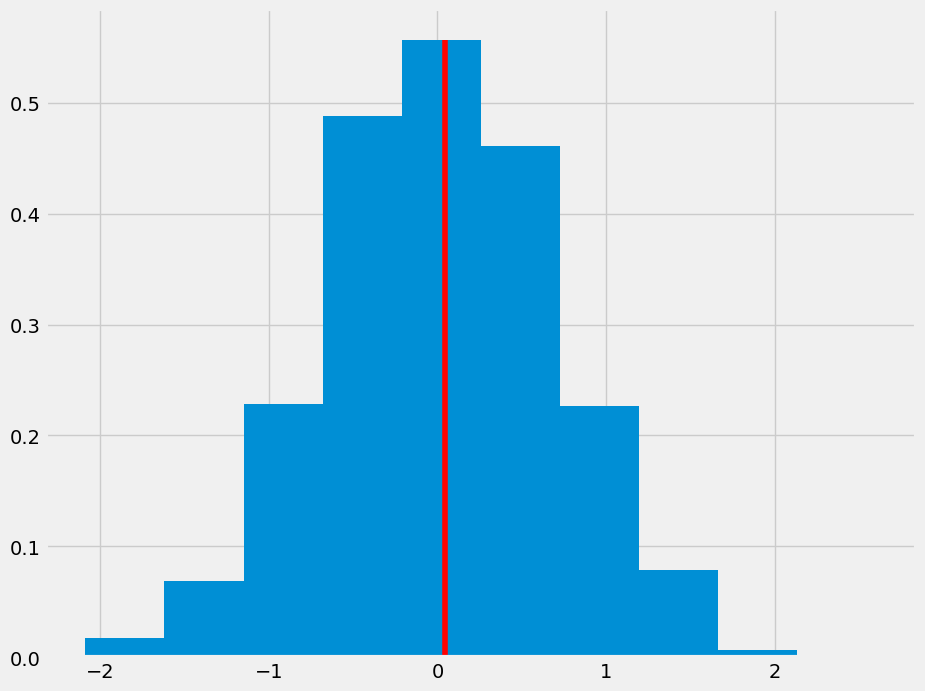

In [31]:

AB_Test_permutation(dataframe=ab, group_column="version", target_column="sum_gamerounds")

# Conclusion

Recalling the core business challenge: as players progress through the game, they encounter gates that impose waiting periods before advancement or in-app purchases. In this project, we have undertaken an in-depth analysis of an A/B test involving the relocation of the initial gate in Cookie Cats from level 30 to level 40. Our primary focus was on evaluating its impact on player retention and game rounds.

Initially, we delved into the data, exploring its structure and relationships. While the data didn't present any missing values, there was a single outlier issue that required attention. Summary statistics and visualizations played a pivotal role in comprehending the data and the challenges it posed.

Before conducting the A/B test, we diligently communicated key game details, player insights, identified issues, and offered potential solutions to our stakeholders, including our customer, director, and CEO.

Following the A/B test, our analysis yielded pivotal insights. The Shapiro Test led to the rejection of the null hypothesis for the normality assumption. Consequently, we opted for a non-parametric test, specifically the Mann Whitney U test, to compare the two groups. The results of this test decisively rejected the null hypothesis, indicating that the A/B groups were indeed dissimilar.

In summary, our analysis reveals a statistically significant difference between the two groups when it comes to relocating the initial gate from level 30 to level 40, particularly with respect to game rounds.

So, which level offers a superior advantage in terms of player retention? One-day and seven-day average retention rates are notably higher when the gate is positioned at level 30 compared to level 40.

In [32]:
ab.groupby("version").retention_1.mean(), ab.groupby("version").retention_7.mean()

(version
 gate_30    0.448198
 gate_40    0.442283
 Name: retention_1, dtype: float64,
 version
 gate_30    0.190183
 gate_40    0.182000
 Name: retention_7, dtype: float64)

The gate placement at level 30 appears to be the preferred option, although the average retention rates seem fairly similar. To draw a more definitive conclusion about their similarity, we would benefit from having a larger dataset.